# **Unsmoothing of linear time series**

Let's first import different dependencies and the data:

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller

In [9]:
alternative_data_raw = pd.read_excel('EnsaeAlternativeTimeSeries.xlsx', sheet_name='Alternative Asset', index_col=0)
alternative_data_raw.tail(10)

,Commodity - USD Unhedged,Global Property USD Unhedged,Hedge Fund DJ - USD Unhedged,Infrastructure Debt - USD Unhedged,Infrastructure Equity Listed - USD Unhedged,Infrastructure Equity USD Unhedged,Nature Capital - USD Hedged,Private Equity USD Unhedged,UK Property Direct - USD Unhedged
QUARTER,,,,,,,,,
2021-Q2,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508
2021-Q3,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387
2021-Q4,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135
2022-Q1,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837
2022-Q2,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741
2022-Q3,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995
2022-Q4,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219
2023-Q1,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907
2023-Q2,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599


# **I. Data Analysis**
## Preprocessing

In [10]:
def tweak_alternative_data(df_):
    return (df_.assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns}) #Adding the returs
            .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime
            .rename(lambda c: c.replace(' ','_'), axis = 1)) # Replacing the spaces by _ in the names


alternative_data = tweak_alternative_data(alternative_data_raw)
alternative_data.tail(10)

/var/folders/8k/vtlzy2q90b7cbr81gv961g_w0000gn/T/ipykernel_26144/2713308186.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .set_index(pd.to_datetime(df_.index)) #Changing the index format to datetime


,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_Listed_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,,,,,,,,,,
2021-04-01,201.8662,6229.774805,711.43,2534.95,NaN,275.181583,1443.470642,4691.699,278.205508,0.133047,0.094214,0.030222,0.020519,NaN,0.017745,0.111440,0.167016,0.056565
2021-07-01,215.1673,6184.521678,719.91,2544.31,NaN,271.066062,1515.657205,4897.288,280.913387,0.065891,-0.007264,0.011920,0.003692,NaN,-0.014956,0.050009,0.043820,0.009733
2021-10-01,211.8033,6825.772548,726.66,2535.15,6096.56,300.214659,1606.789837,5397.431,305.081135,-0.015634,0.103686,0.009376,-0.003600,NaN,0.107533,0.060127,0.102127,0.086033
2022-01-01,265.9137,6568.538826,742.17,2386.29,6552.00,293.265256,1777.360304,4770.109,290.587837,0.255475,-0.037686,0.021344,-0.058718,0.074704,-0.023148,0.106156,-0.116226,-0.047506
2022-04-01,250.8549,5436.569419,725.12,2267.73,6065.58,263.147689,1890.893920,3612.590,236.794741,-0.056630,-0.172332,-0.022973,-0.049684,-0.074240,-0.102697,0.063878,-0.242661,-0.185118
2022-07-01,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764
2022-10-01,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531
2023-01-01,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827
2023-04-01,226.7436,5241.647937,748.09,2248.24,6318.26,241.619726,NaN,4311.668,211.147599,-0.025624,0.005429,0.017062,0.003213,-0.001173,-0.034827,NaN,0.084293,-0.014544


##  Data Visualisation

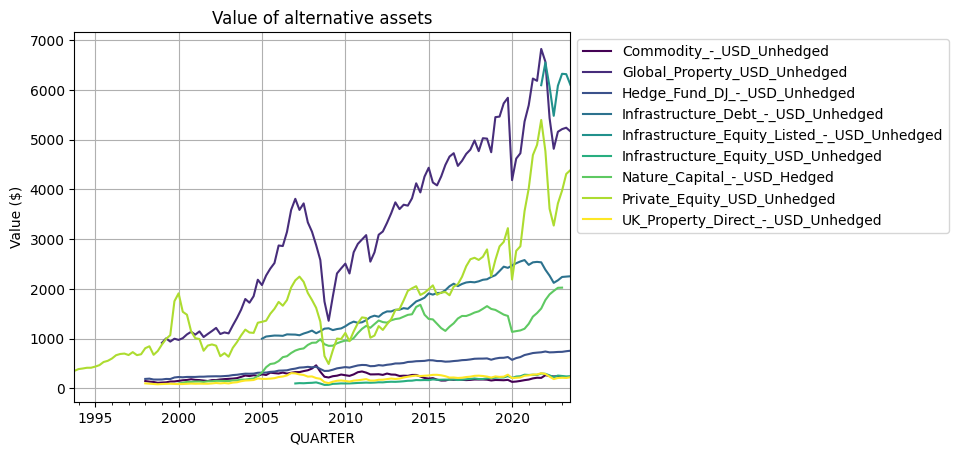

In [11]:
(alternative_data.iloc[:,0:9]
.plot(cmap = 'viridis',grid=True,ylabel='Value ($)', title='Value of alternative assets')
.legend(bbox_to_anchor = (1,1)))

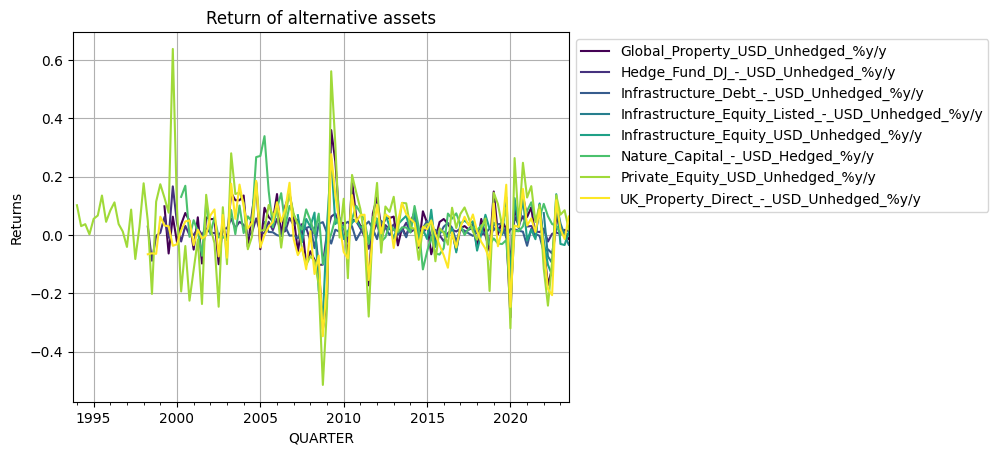

In [12]:
(alternative_data.iloc[:,10:]
.plot(cmap = 'viridis',grid=True,ylabel='Returns', title='Return of alternative assets')
.legend(bbox_to_anchor = (1,1)))

##  Stationarity analysis 

In [13]:
unit_test = {name: (adfuller(alternative_data[name].dropna())[0], adfuller(alternative_data[name].dropna())[1]) 
       for name in alternative_data.iloc[:,10:].columns}

(pd.DataFrame(unit_test, index = ['value','p-value']).T.style.format(precision = 2)
.background_gradient(cmap = 'viridis'))

,value,p-value
Global_Property_USD_Unhedged_%y/y,-8.58,0.00
Hedge_Fund_DJ_-_USD_Unhedged_%y/y,-8.99,0.00
Infrastructure_Debt_-_USD_Unhedged_%y/y,-7.14,0.00
Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,-2.62,0.09
Infrastructure_Equity_USD_Unhedged_%y/y,-8.06,0.00
Nature_Capital_-_USD_Hedged_%y/y,-5.63,0.00
Private_Equity_USD_Unhedged_%y/y,-9.30,0.00
UK_Property_Direct_-_USD_Unhedged_%y/y,-8.59,0.00


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


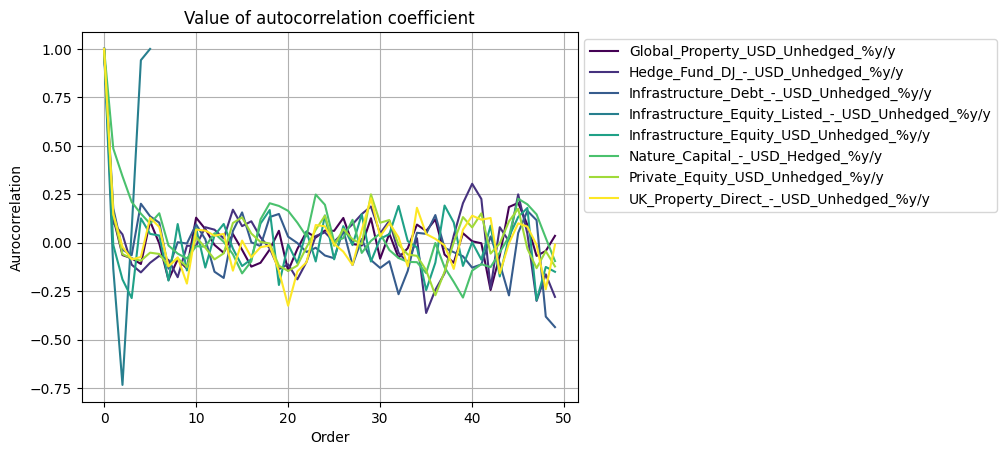

In [14]:
serial_correlation = pd.DataFrame({name:  [alternative_data[name].dropna().autocorr(k) for k in range (50)]
                       for name in alternative_data.iloc[:,10:].columns})

(serial_correlation
.plot(grid = True, cmap  = 'viridis', xlabel='Order', ylabel ='Aurocorrelation', title = 'Value of autocorrelation coefficient' )
.legend(bbox_to_anchor = (1,1)))

# **II. Autoregressive method**
##  Unsmoothing series

In [15]:
from AR_Model.AR_functions import AR_model

In [16]:
def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2)
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed = data_unsmoothing(alternative_data.iloc[:,10:])
unsmoothed.tail(15)

,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,Private_Equity_USD_Unhedged_%y/y_unsmoothed,UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed
QUARTER,,,,,,,,,,,,,,,,
2022-05-01,-0.176381,-0.020622,-0.055896,-0.102969,-0.132958,0.051144,-0.221291,-0.219314,-0.180431,-0.018270,-0.062109,-0.131698,-0.163219,0.038411,-0.199921,-0.253510
2022-06-01,-0.155571,-0.006895,-0.067673,-0.117865,-0.161746,0.042215,-0.164770,-0.240757,-0.134760,0.006832,-0.079449,-0.132760,-0.190535,0.033286,-0.108249,-0.262200
2022-07-01,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764,-0.072164,0.013956,-0.060147,-0.074849,-0.114378,0.031490,-0.022474,-0.172772
2022-08-01,-0.048953,0.008921,-0.040776,-0.033209,-0.051677,0.034556,-0.006074,-0.107801,0.015961,0.014312,-0.017642,0.029940,0.034708,0.032260,0.081474,-0.008838
2022-09-01,0.029372,0.009401,-0.002668,0.059176,0.077943,0.034617,0.087023,0.036949,0.107697,0.009880,0.035439,0.151562,0.207563,0.034677,0.180119,0.181698
2022-10-01,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531,0.112766,0.006953,0.050549,0.161541,0.200628,0.029158,0.184666,0.200114
2022-11-01,0.071213,0.005659,0.036792,0.112890,0.119134,0.025360,0.135991,0.125601,0.071356,0.003141,0.049643,0.115420,0.098982,0.018832,0.136138,0.132671
2022-12-01,0.036844,0.002607,0.036375,0.074151,0.033377,0.015454,0.096193,0.069347,0.002475,-0.000445,0.035958,0.035412,-0.052379,0.005549,0.056395,0.013093
2023-01-01,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827,-0.016126,0.002600,0.025660,0.004610,-0.095843,-0.012432,0.042172,-0.029693


## Results visualisation

### Cumulated returns:

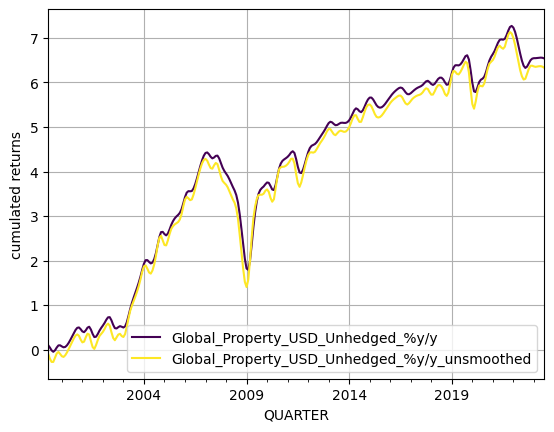

In [17]:
(unsmoothed.iloc[:,[0,8]].cumsum().dropna()
.plot(grid = True, cmap = 'viridis',ylabel='cumulated returns')
.legend())


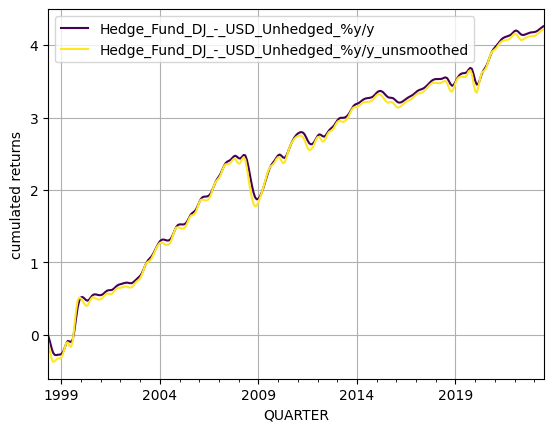

In [18]:
(unsmoothed.iloc[:,[1,9]].cumsum().dropna()
.plot(grid = True, cmap = 'viridis',ylabel='cumulated returns')
.legend())


### Interpolation:

Text(0.5, 1.0, 'Year 2018 interpolation')

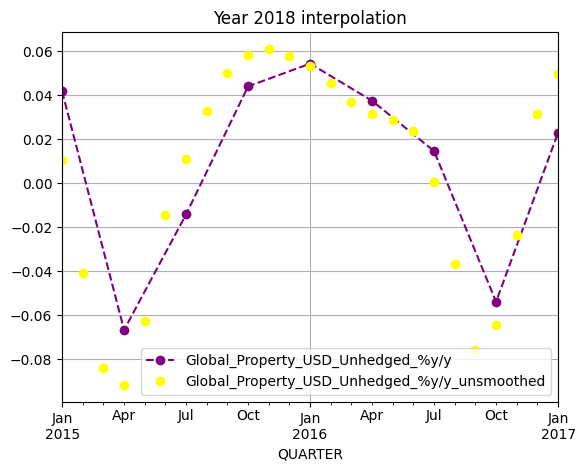

In [19]:
fig, axis = plt.subplots()
(unsmoothed.loc['2015-01-01':'2017-01-01', unsmoothed.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'purple')
 .legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[8]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend())

axis.set_title('Year 2018 interpolation')

###  Serial correlation:

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


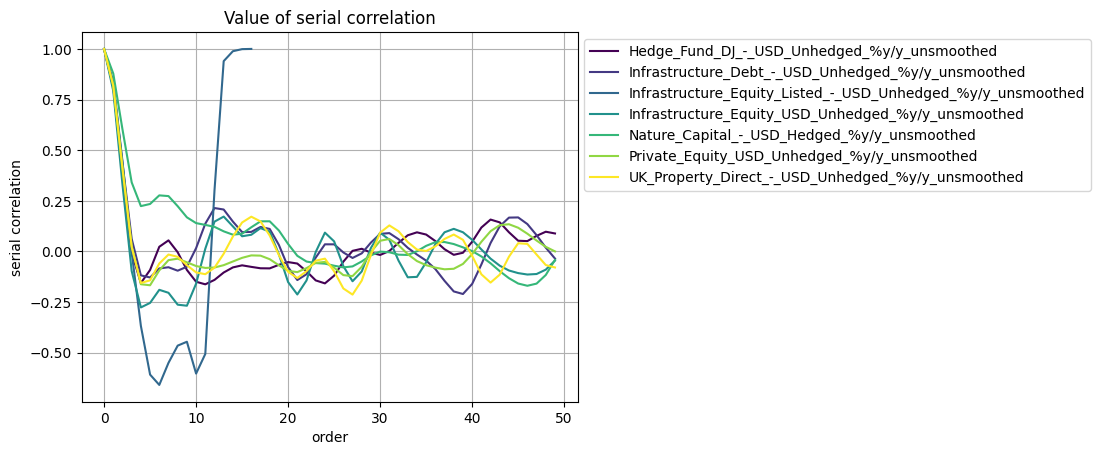

In [20]:
serial_correlation_unsmoothed = pd.DataFrame({name:[unsmoothed[name].dropna().autocorr(k) for k in range (50)]
for name in unsmoothed.iloc[:,9:].columns})

(serial_correlation_unsmoothed
.plot(grid = True, cmap  = 'viridis', xlabel='order', ylabel ='serial correlation', title = 'Value of serial correlation' )
.legend(bbox_to_anchor = (1,1)))

In [21]:
unsmoothed.tail()

,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y_unsmoothed,Hedge_Fund_DJ_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Debt_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y_unsmoothed,Infrastructure_Equity_USD_Unhedged_%y/y_unsmoothed,Nature_Capital_-_USD_Hedged_%y/y_unsmoothed,Private_Equity_USD_Unhedged_%y/y_unsmoothed,UK_Property_Direct_-_USD_Unhedged_%y/y_unsmoothed
QUARTER,,,,,,,,,,,,,,,,
2023-03-01,0.003636,0.012477,0.011611,0.008436,-0.048436,NaN,0.078917,-0.017372,0.006816,0.018525,0.001186,-0.001008,-0.040751,NaN,0.092139,-0.026032
2023-04-01,0.005429,0.017062,0.003213,-0.001173,-0.034827,NaN,0.084293,-0.014544,0.007221,0.021647,-0.005186,-0.010782,-0.021218,NaN,0.089668,-0.011717
2023-05-01,0.003077,0.018612,-0.000882,-0.011211,-0.020959,NaN,0.075963,-0.000402,0.000725,0.020162,-0.004977,-0.021249,-0.007090,NaN,0.067634,0.013740
2023-06-01,-0.003577,0.017231,-0.000946,-0.022348,-0.005906,NaN,0.053374,0.025997,-0.010230,0.015849,-0.001010,-0.033484,0.009147,NaN,0.030785,0.052397
2023-07-01,-0.014102,0.013006,0.003025,-0.033864,0.009360,NaN,0.017983,0.062951,-0.024627,0.008782,0.006995,-0.045380,0.024627,NaN,-0.017408,0.099904


### Volatility:

In [22]:
import numpy as np

def volatility_from_month(x):
    return np.sqrt(12)*x.sem()

<Axes: xlabel='QUARTER'>

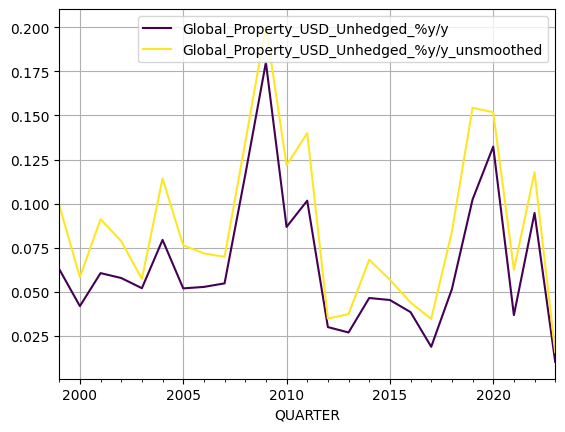

In [23]:
(unsmoothed.iloc[:,[0,8]].resample('YS')
.agg(volatility_from_month)
.dropna()
.plot(grid = True, cmap = 'viridis'))

<Axes: xlabel='QUARTER'>

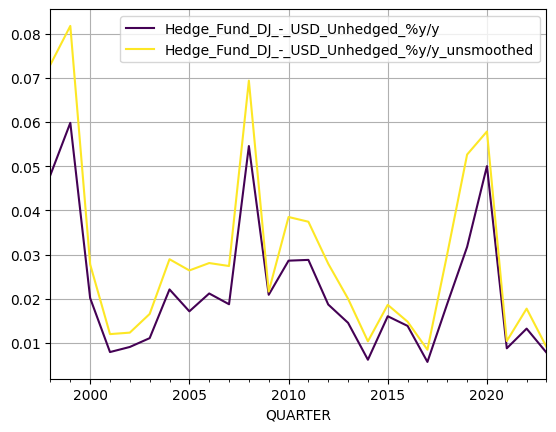

In [24]:
(unsmoothed.iloc[:,[1,9]].resample('YS')
.agg(volatility_from_month)
.dropna()
.plot(grid = True, cmap = 'viridis'))

## Alternative: Linear interpolation
###  Applying linear interpolation:

In [25]:
def data_unsmoothing_linear(df_):
    new = df_.resample('MS').interpolate(method='linear')
    for col in df_.columns:
        new[col + '_unsmoothed'] = AR_model(new[col].values)
    return new


unsmoothed_linear = data_unsmoothing_linear(alternative_data.iloc[:,10:])


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.wa

Text(0.5, 1.0, 'Year 2018 interpolation')

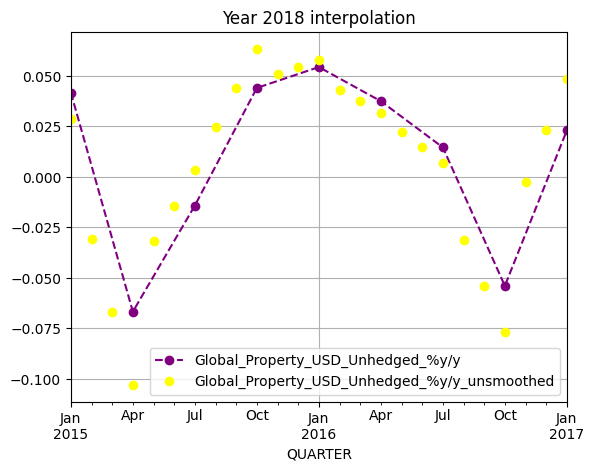

In [26]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'purple')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[8]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend())

axis.set_title('Year 2018 interpolation')

Text(0.5, 1.0, 'Year 2018 interpolation: Linear vs Quadratic')

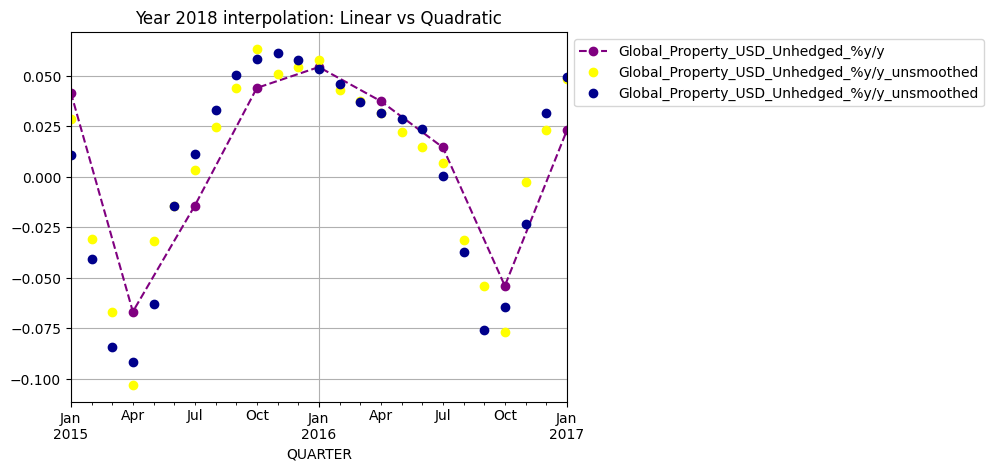

In [27]:
fig, axis = plt.subplots()
(unsmoothed_linear.loc['2015-01-01':'2017-01-01', unsmoothed_linear.columns[0]]
 .iloc[::3]
 .plot(ax = axis, style = 'o--', grid = True, c = 'purple')
 .legend())

(unsmoothed_linear.loc['2015-01-01':'2017-01-01',unsmoothed_linear.columns[8]]
.plot(ax = axis, style = 'o',grid = True, c='yellow')
.legend())

(unsmoothed.loc['2015-01-01':'2017-01-01',unsmoothed.columns[8]]
.plot(ax = axis, style = 'o',grid = True, c='darkblue')
.legend(bbox_to_anchor = (1,1)))

axis.set_title('Year 2018 interpolation: Linear vs Quadratic')

### Rolling window (Eh bah non)

In [29]:
def data_unsmoothing(df_):
    new = df_.resample('MS').interpolate(method='polynomial', order = 2)
    for col in df_.columns:
        new[col + '_unsmoothed'] = new[col].rolling(window = 5).apply(lambda x: AR_model(x.to_numpy()))
    return new


unsmoothed = data_unsmoothing(alternative_data.iloc[:,10:])
unsmoothed.tail(15)

TypeError: only length-1 arrays can be converted to Python scalars

## **III. Getmansky, Lo, Makarov Model**

In [259]:
from web_app.apps.Models.getmansky.GetmanskyMain import GetmanskyModel

In [109]:
alternative_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Alternative Asset", index_col=0)
)

def tweak_data(df_):
    return (df_
            .assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns})
            .rename(lambda c: c.replace(' ','_'), axis = 1)
        )

alternative_asset_data = tweak_data(alternative_asset_data)
alternative_asset_data

,Commodity_-_USD_Unhedged,Global_Property_USD_Unhedged,Hedge_Fund_DJ_-_USD_Unhedged,Infrastructure_Debt_-_USD_Unhedged,Infrastructure_Equity_Listed_-_USD_Unhedged,Infrastructure_Equity_USD_Unhedged,Nature_Capital_-_USD_Hedged,Private_Equity_USD_Unhedged,UK_Property_Direct_-_USD_Unhedged,Commodity_-_USD_Unhedged_%y/y,Global_Property_USD_Unhedged_%y/y,Hedge_Fund_DJ_-_USD_Unhedged_%y/y,Infrastructure_Debt_-_USD_Unhedged_%y/y,Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y,Infrastructure_Equity_USD_Unhedged_%y/y,Nature_Capital_-_USD_Hedged_%y/y,Private_Equity_USD_Unhedged_%y/y,UK_Property_Direct_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,,,,,,,,,,
1993-Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,353.280,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-Q1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,389.140,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.101506,NaN
1994-Q2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,400.750,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.029835,NaN
1994-Q3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,415.450,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.036681,NaN
1994-Q4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,416.120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.001613,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-Q3,240.5519,4817.520307,727.68,2122.80,5481.12,226.816903,1960.578024,3274.373,187.833995,-0.041072,-0.113868,0.003530,-0.063910,-0.096357,-0.138062,0.036852,-0.093622,-0.206764
2022-Q4,245.8892,5159.896609,733.63,2173.62,6086.01,258.409265,2023.095816,3719.178,210.098219,0.022188,0.071069,0.008177,0.023940,0.110359,0.139286,0.031887,0.135844,0.118531
2023-Q1,232.7065,5213.347074,735.54,2241.04,6325.68,250.338364,2026.152916,3976.480,214.263907,-0.053612,0.010359,0.002603,0.031017,0.039380,-0.031233,0.001511,0.069182,0.019827


In [256]:
classic_asset_data = (
    # Importing the dataset
    pd.read_excel("./EnsaeAlternativeTimeSeries.xlsx", sheet_name= "Classic Asset", index_col=1)
)

def tweak_data(df_):
    return (
        df_
        .resample('ME')
        .last()
        .assign(**{col + '_%y/y': df_[col].pct_change(fill_method = None) for col in df_.columns if df_[col].dtype != object})
        .rename(lambda c: c.replace(' ','_'), axis = 1)
        .reset_index()
        .assign(QUARTER=lambda x: x["QUARTER"].bfill()) #only one value is missing in the dataframe
        .set_index("QUARTER")        
    )

classic_asset_data = tweak_data(classic_asset_data)
classic_asset_data

,Date,Liquidity_USD_Unhedged,US_Equity_USD_Unhedged,US_Government_Bond_USD_Unhedged,USD_Corporate_Bond_-_USD_Unhedged,Liquidity_USD_Unhedged_%y/y,US_Equity_USD_Unhedged_%y/y,US_Government_Bond_USD_Unhedged_%y/y,USD_Corporate_Bond_-_USD_Unhedged_%y/y
QUARTER,,,,,,,,,
1998-Q1,1998-02-28,145.464901,2946.083000,241.530000,949.244263,NaN,NaN,NaN,NaN
1998-Q1,1998-03-31,146.135886,3099.360000,242.190000,952.750061,0.004613,0.052027,0.002733,0.003693
1998-Q2,1998-04-30,146.872656,3136.193000,243.270000,958.766296,0.005042,0.011884,0.004459,0.006315
1998-Q2,1998-05-31,147.551539,3073.750000,245.790000,970.149414,0.004622,-0.019910,0.010359,0.011873
1998-Q2,1998-06-30,148.232494,3206.355000,248.630000,977.322327,0.004615,0.043141,0.011555,0.007394
...,...,...,...,...,...,...,...,...,...
2023-Q2,2023-04-30,118.444827,18414.905335,604.922865,3095.666047,NaN,NaN,NaN,NaN
2023-Q2,2023-05-31,118.990836,18534.693812,597.900543,3050.833843,0.000143,-0.005608,0.003326,0.002719
2023-Q2,2023-06-30,119.497744,19770.619413,593.410756,3063.387009,0.000142,0.012186,0.002510,0.005197


In [396]:
start_date = "2013-01-01" # format "YYYY-MM-DD"
end_date = "2022-12-31" # format "YYYY-MM-DD"
weight_type = "sumOfYears" # choose between : sumOfYears, equal, geometric or optimized
order = 2 # choose an int
window = None # choose an int or put None
benchmark = 'US_Equity_USD_Unhedged_%y/y' #one of the following list :
# 'Liquidity_USD_Unhedged_%y/y'
# 'US_Equity_USD_Unhedged_%y/y'
# 'US_Government_Bond_USD_Unhedged_%y/y'
# 'USD_Corporate_Bond_-_USD_Unhedged_%y/y'


df = (
    classic_asset_data
    .copy()
    .merge(alternative_asset_data, how = 'inner', left_index = True, right_index = True)
    .set_index("Date")
    .loc[start_date:end_date]
)

#deal with potential missing values
if df.isna().any().any():
    df.interpolate(method='linear', inplace=True)

for col in filter(lambda x: "%y/y" in x, alternative_asset_data.columns):
    getmansky = GetmanskyModel(order)

    if weight_type != "optimized":
        getmansky.set_default_weights(weight_type)
    else:
        getmansky.optimize_weights_LR(df[benchmark].values.reshape(-1, 1), 
                  df[col].values.reshape(-1,1)
                )
        
    getmansky.fit(df[benchmark].values.reshape(-1, 1), 
                  df[col].values.reshape(-1,1), 
                  window = window
                )
    df[col+'_unsmoothed'] = getmansky.predict(df[benchmark])

df = (
    df
    .assign(**{
        col: df[col].mul(pd.Series(
            [0 if date.month in [1, 2, 4, 5, 7, 8, 10, 11] else 1 for date in df[col].index],
            index = df[col].index
            )) 
        for col in alternative_asset_data.columns
    })
    .assign(**{
        col + '_TR': (df[col]+1).cumprod()-1
        for col in df.columns if "%y/y" in col
    })
)




In [397]:
print(alternative_asset_data.columns)

Index(['Commodity_-_USD_Unhedged', 'Global_Property_USD_Unhedged',
       'Hedge_Fund_DJ_-_USD_Unhedged', 'Infrastructure_Debt_-_USD_Unhedged',
       'Infrastructure_Equity_Listed_-_USD_Unhedged',
       'Infrastructure_Equity_USD_Unhedged', 'Nature_Capital_-_USD_Hedged',
       'Private_Equity_USD_Unhedged', 'UK_Property_Direct_-_USD_Unhedged',
       'Commodity_-_USD_Unhedged_%y/y', 'Global_Property_USD_Unhedged_%y/y',
       'Hedge_Fund_DJ_-_USD_Unhedged_%y/y',
       'Infrastructure_Debt_-_USD_Unhedged_%y/y',
       'Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y',
       'Infrastructure_Equity_USD_Unhedged_%y/y',
       'Nature_Capital_-_USD_Hedged_%y/y', 'Private_Equity_USD_Unhedged_%y/y',
       'UK_Property_Direct_-_USD_Unhedged_%y/y'],
      dtype='object')


In [381]:
alternative_asset_data.columns

Index(['Commodity_-_USD_Unhedged', 'Global_Property_USD_Unhedged',
       'Hedge_Fund_DJ_-_USD_Unhedged', 'Infrastructure_Debt_-_USD_Unhedged',
       'Infrastructure_Equity_Listed_-_USD_Unhedged',
       'Infrastructure_Equity_USD_Unhedged', 'Nature_Capital_-_USD_Hedged',
       'Private_Equity_USD_Unhedged', 'UK_Property_Direct_-_USD_Unhedged',
       'Commodity_-_USD_Unhedged_%y/y', 'Global_Property_USD_Unhedged_%y/y',
       'Hedge_Fund_DJ_-_USD_Unhedged_%y/y',
       'Infrastructure_Debt_-_USD_Unhedged_%y/y',
       'Infrastructure_Equity_Listed_-_USD_Unhedged_%y/y',
       'Infrastructure_Equity_USD_Unhedged_%y/y',
       'Nature_Capital_-_USD_Hedged_%y/y', 'Private_Equity_USD_Unhedged_%y/y',
       'UK_Property_Direct_-_USD_Unhedged_%y/y'],
      dtype='object')

## Comparison Getmansky vs AR(1)

In [ ]:
from getmansky.GetmanskyMain import GetmanskyModel